In [114]:
import numpy as np
from scipy import constants as cst
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=3
    ),
    transitions.MicrowaveTransition(
        J_ground=1,
        J_excited=2,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [99]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=0 -> J=1 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [5]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
    Jmax_X=4,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 2, F₁ = 5/2, F = 3>"
states,
"|X, J = 1>",0.523531
"|X, J = 3>",0.476469


In [8]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 2, F₁ = 5/2, F = 3>"
states,
"|X, J = 1, F₁ = 3/2, F = 2>",0.523531
"|X, J = 3, F₁ = 5/2, F = 2>",0.002250
"|X, J = 3, F₁ = 5/2, F = 3>",0.043735
"|X, J = 3, F₁ = 7/2, F = 3>",0.015063
"|X, J = 3, F₁ = 7/2, F = 4>",0.415421


In [100]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

## Calculate rabi rates and population density

In [274]:
ρ = generate_thermal_population_states(
    temperature=6.3,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

In [275]:
power = 85e-3
intensity = power / (25.4e-3 * 25.4e-3)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real

rabi_microwave_12 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[1].main_coupling,
    sigma_x=25.4e-3,
    sigma_y=25.4e-3,
).real

## J12 microwave on

In [297]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_12
odepars.ω1 = 2 * np.pi * 1.56e6

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [298]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [299]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

In [300]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [301]:
import copy

res = copy.deepcopy(results)

res.y[indices_J2[0], :] = res.y[indices_J2].mean(axis=0)
res.y = np.delete(res.y, obj=indices_J2[1:], axis=0)

1.26 photons


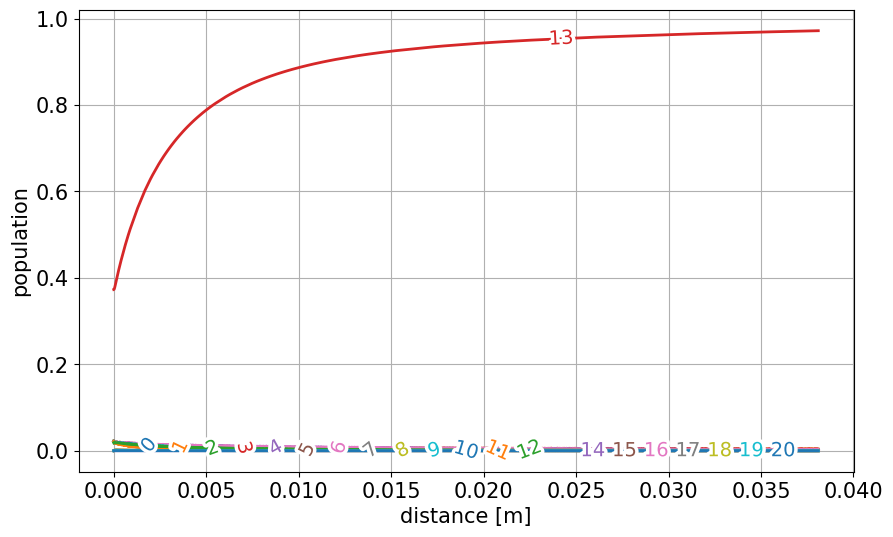

In [302]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [305]:
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
print(f"{1-results.y[indices_J3][0][-1]:>5.3f} remaining in J=1,2 of total in J=1,2,3")
print(f"{1-results.y[indices_J3][0][-1]:>5.1%} remaining in J=1,2 of total in J=1,2,3")

0.028 remaining in J=1,2 of total in J=1,2,3
 2.8% remaining in J=1,2 of total in J=1,2,3


1.26 photons


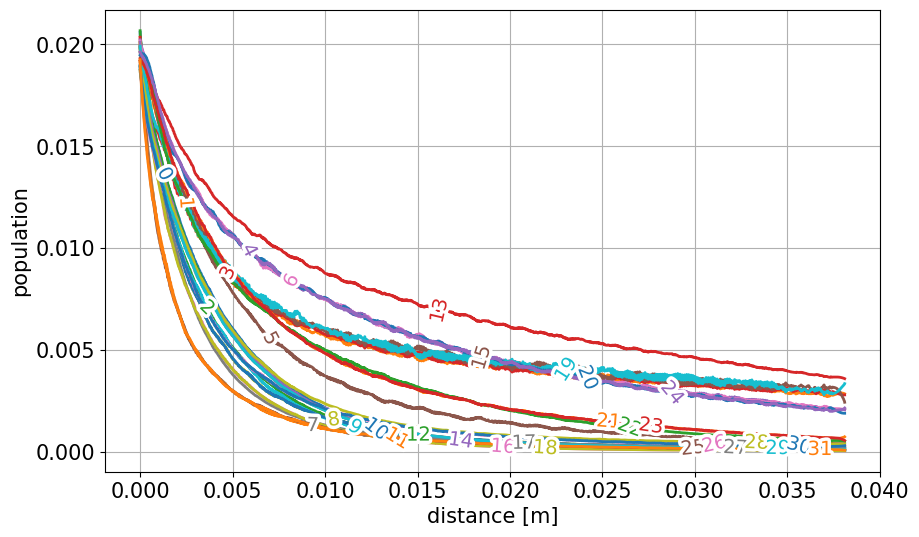

In [283]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]

indices_select = np.append(indices_J1, indices_J2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    res.t * odepars.vz,
    savgol_filter(
        x=results.y[indices_select].T, window_length=201, polyorder=3, axis=0
    ),
    lw=2,
    label=np.arange(len(indices_select)),
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [309]:
print(f"{results.y[indices_select][:,-1].sum():.3f} population remaining in J=1,2")
print(
    f"{results.y[indices_select][:,-1].sum() / results.y[indices_select][:,0].sum():.1%} population"
    " remaining in J=1,2 that started in J=1,2"
)

0.028 population remaining in J=1,2
4.5% population remaining in J=1,2 that started in J=1,2


1.26 photons


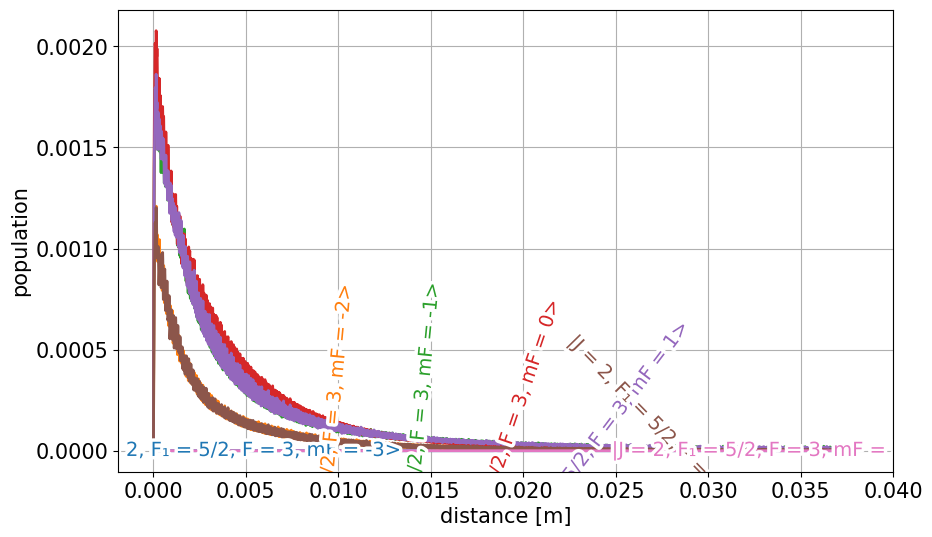

In [285]:
labels = np.array(
    [
        f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}"
        for qn in obe_system.QN
    ]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results.t * odepars.vz,
    results.y[indices_excited].T,
    lw=2,
    label=labels[indices_excited],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

## J12 microwave off

In [286]:
odepars.Ωl0 = rabi
odepars.Ω1 = 0

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [287]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [288]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

In [289]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [290]:
import copy

res = copy.deepcopy(results)

res.y[indices_J2[0], :] = res.y[indices_J2].mean(axis=0)
res.y = np.delete(res.y, obj=indices_J2[1:], axis=0)

0.23 photons


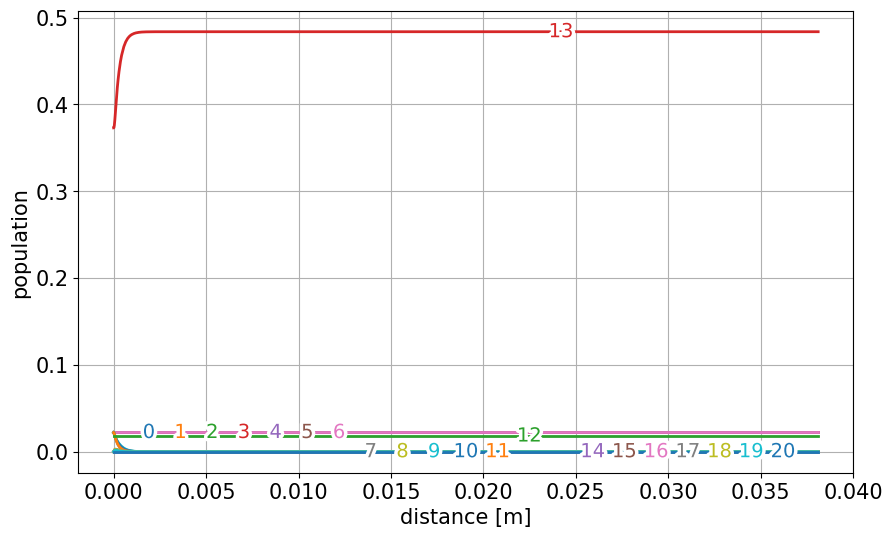

In [291]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.23 photons


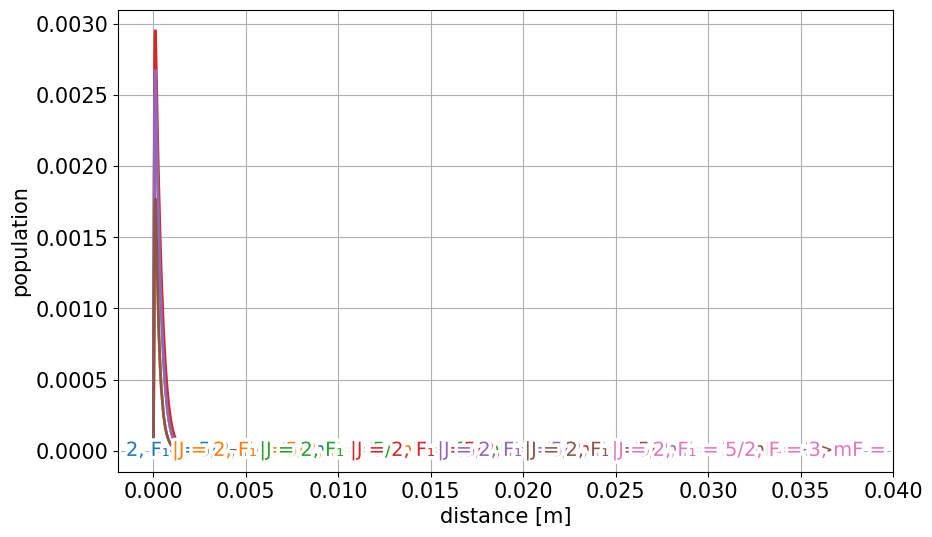

In [292]:
labels = np.array(
    [
        f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}"
        for qn in obe_system.QN
    ]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results.t * odepars.vz,
    results.y[indices_excited].T,
    lw=2,
    label=labels[indices_excited],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [293]:
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [294]:
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
print(f"{results.y[indices_J1_F2].sum(axis=0)[-1]:>5.3f} remaining in J=1, F=2")
print(f"{results.y[indices_J1_F2].sum(axis=0)[-1]:>5.1%} remaining in J=1, F=2")

0.000 remaining in J=1, F=2
 0.0% remaining in J=1, F=2


## Temperature Scan

In [26]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

res = []
for T in tqdm.tqdm(np.linspace(4, 18, 11)):
    ρ = generate_thermal_population_states(
        temperature=T,
        QN=obe_system.QN,
    )
    ρ /= np.trace(ρ)

    res_toggle = []
    for Ωmu in [0, rabi_microwave_12]:
        odepars.Ωl0 = rabi
        odepars.Ω1 = Ωmu

        problem = lindblad_julia.OBEProblem(
            odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz)
        )
        config = lindblad_julia.OBEProblemConfig(saveat=5e-7, abstol=1e-8, reltol=1e-5)

        results = lindblad_julia.do_simulation_single(problem, config=config)

        nphotons = (
            np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
        )

        res_toggle.append(nphotons)

    res.append((T, res_toggle[1] / res_toggle[0]))

100%|██████████| 11/11 [01:30<00:00,  8.25s/it]


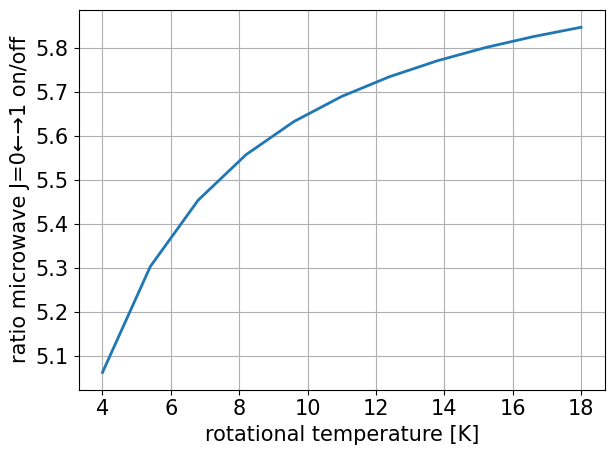

In [27]:
T, ratio = list(zip(*res))

fig, ax = plt.subplots()

ax.plot(T, ratio, lw=2)
ax.set_xlabel("rotational temperature [K]")
ax.set_ylabel("ratio microwave J=1←→2 on/off")
fig.tight_layout()
ax.grid(True)

## Ensemble Simulation with Temperature and microwave power

In [33]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [34]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [36]:
rabis = np.linspace(0, 1, 21) * hamiltonian.Γ

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    save_everystep=True,
    abstol=1e-8,
    reltol=1e-5,
    saveat=1e-6,
)


results_temperature_power = []
for T in tqdm.tqdm(np.linspace(4, 18, 11)):
    ρ = generate_thermal_population_states(
        temperature=T,
        QN=obe_system.QN,
    )

    problem = lindblad_julia.OBEProblem(
        odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz)
    )

    scan_values = [rabis]
    parameters = ["Ω1"]

    output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(
        nphotons=True
    )

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem,
        parameters=parameters,
        scan_values=scan_values,
        output_func=output_func,
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

    results = lindblad_julia.get_results_parameter_scan(ensemble_problem)

    results_temperature_power.append(results)

100%|██████████| 11/11 [1:35:52<00:00, 522.94s/it]


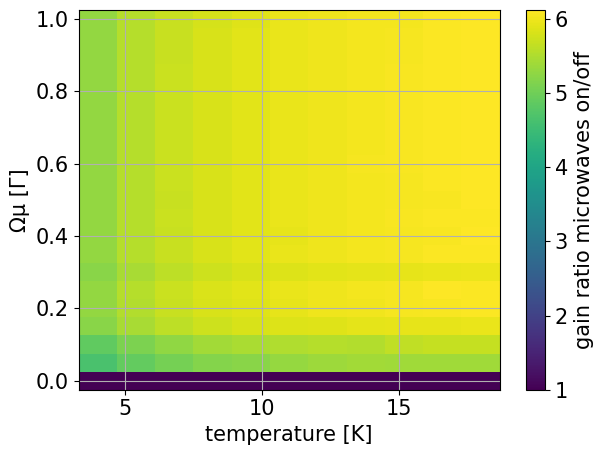

In [97]:
X, Y = np.meshgrid(
    np.linspace(4, 18, 11), results_temperature_power[0].scan_values, indexing="ij"
)

data = np.array([r.results for r in results_temperature_power])

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y / hamiltonian.Γ, data / data[:, 0][:, np.newaxis])
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("gain ratio microwaves on/off")
ax.set_xlabel("temperature [K]")
ax.set_ylabel("Ωμ [Γ]")
fig.tight_layout()
ax.grid(True)

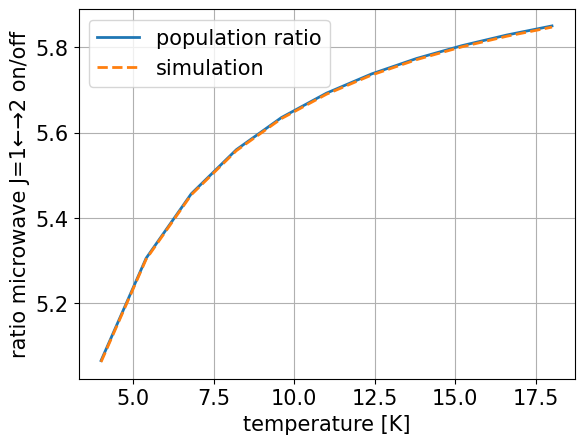

In [312]:
Ts = np.unique(X)

populations = np.array(
    [utils.population.thermal_population(J=np.arange(1, 4), T=Ti) for Ti in Ts]
)

J1_hfs = J_levels(1)
J1_hfs_active = (1 + 1) * 2 + 1

# 2.8% of the population stays in J=1 and 2, i.e. 4.5% of the original population in J=1
# and 2
population_removed = 1 - 4.5e-2

signal_before = populations[:, 0] * J1_hfs_active / J1_hfs
signal_after = population_removed * np.sum(populations[:, :2], axis=1)

fig, ax = plt.subplots()
ax.plot(Ts, signal_after / signal_before, lw=2, label="population ratio")
ax.plot(np.linspace(4, 18, 11), ratio, ls="--", lw=2, label="simulation")
ax.set_xlabel("temperature [K]")
ax.set_ylabel("ratio microwave J=1←→2 on/off")
ax.legend()
ax.grid(True)